In [26]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

# import warnings

In [27]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

In [28]:
sw_indo = stopwords.words("indonesian") + list(punctuation) #buang puctuation

# bisa jadi punctuation yang di anggap sebagai stopword dalam sentiment 
# jika ada tanda seru tandanya sentiment negatif, makanya stopword 
# tanda seru jangan dihilangkan

### Import Data

In [29]:
df = pd.read_csv("./data/gojek_review_sentiment.csv")
df.head()

,review,rate
0,Apa aplikasi yang bagus untuk dengan mudah per...,positive
1,Aplikasi ini banyak membantu saya. Sekarang sa...,positive
2,Mengerikan. Antarmukanya sangat membingungkan....,negative
3,Aplikasi yang cukup mengesankan. Butuh waktu l...,positive
4,Aplikasi ini sebenarnya bagus dan sangat memba...,positive


In [30]:
df.rate.value_counts()

negative    1061
positive     721
Name: rate, dtype: int64

In [31]:
# cek normalisasi keseimbangannya
df.rate.value_counts(normalize=True)

# oleh karena itu, jika masih seimbang, boleh hanya menggunakan akurasi saja tanpa menggunakan klasifikasi report seperti,
# tidak usah pakai f1-score dll, jika tidak balance menggunakan parameter pengukuran lain
# agar lebih fair

negative    0.595398
positive    0.404602
Name: rate, dtype: float64

#### Karena ini menggunakan tools lain gensim (FastText) jadi harus kerjain diluar pipeline kaya biasa yang sebelumnya

### Encoding
merubah kalimat menjadi vektor

In [32]:
from gensim.models import FastText

In [33]:
# ini buat file model sendiri
# load model fasttext
w2v = FastText.load("model/fasttext/gojek_review.fasttext").wv

analogi step by step untuk satu kalimat dari word2vec menjadi satu vektor kalimat (menjawab permasalahan 1)
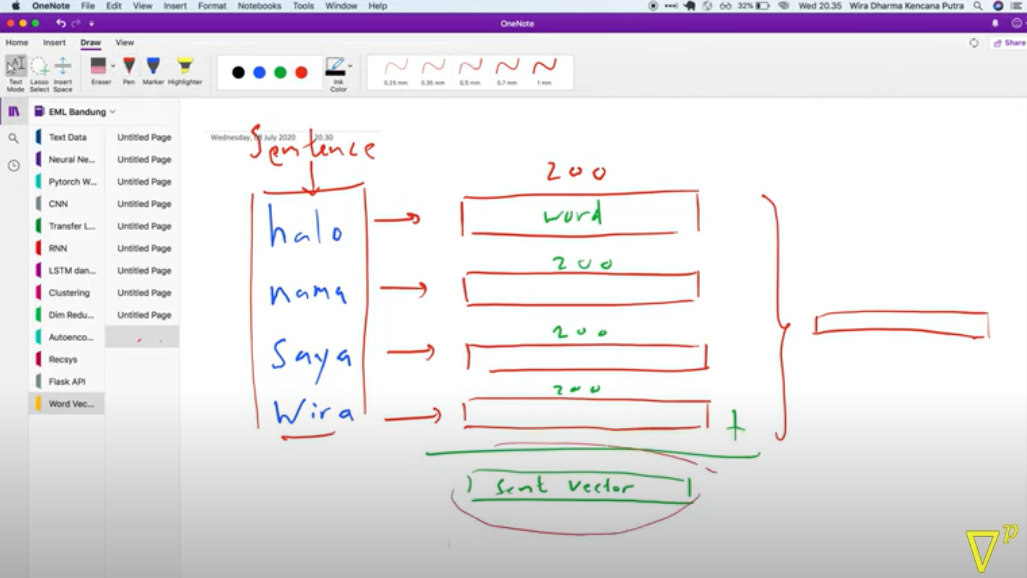

In [34]:
from numpy import linalg as LA

In [35]:
def sent_vector(sentence, w2v_model, stopwords):
    # untuk setiap word di dalam word tokenize sentence, maka wordnya dijadikan vektor,
    # dan jadikan vektornya dalam kurung siku kalo di gensim, modelnya sudah seperti dictionary di word vector
    # kemudian ada langkah kondisi untuk filter = jika kata tersebut tidak ada didalam stopwords
    vecs = [w2v_model[word.lower()] for word in word_tokenize(sentence) if word not in stopwords]
    # ada 2 langkah sekaligus, di tokenize lalu dijadikan vektor, 
    
    # setelah dijadikan vektor kemudian di rata2in
    sent_vec = np.mean(vecs, axis=0)
    # axis = 0 artinya untuk masing2 dari arah baris
    
    return sent_vec
#dan itulah vektor kalimatdengan menggunakan word vector (pake word vec tapi target akhirnya tetep mau sentence to vec, butuh sentence menjadi 1 vektor
#tapi vektor jd efisien cuma 200 dimensi, sedangkan bow banyak sekali vocab yaitu 200k an vocab, kolomnya sebanyak itu.
#oleh karena itu cara tersebut lebih efisien)
    
"""
bagaimana sebuah kalimat tapi wordvec bisa jd sentencevector?
teknik resminya dibawah berikut
=> kalo fasttext idenya jangan cuma sekedar dirata ratain doang, kalo bisa ke empat vector 
dinormalisasi dahulu seperti pada softmax
=> cari (pythagorasnya) besar setiap vektor tersebut kemudian dibagi supaya jadi ternormalisasi
"""

def norm_sent_vector(sentence, w2v_model, stopwords):
    vecs = [w2v_model[word.lower()] for word in word_tokenize(sentence) if word not in stopwords]
    
    #normalisasi vektor
    #penjelasan kode
    #untuk setiap vektor didalam vecs, maka vektornya ini dibagi dengan besarnya vec (pythagoras=np.linalg.norm)
    #(kemudian prosesnya masukkan ke dalam siku = proses gensim)
#     norm_vecs = [vec / np.linalg.norm(vec) for vec in vecs if np.linalg.norm(vec) > 0]
    """
    tetapi hati2 bisa saja setelah dihitung pytagorasnya, besar dari vektor 0, sesuatu yang dibagi 0 = tak hingga,
    oleh karena itu bisa ditambahin kodingan kondisi agar lebih aman yaitu dengan cara di cek, jika hasil
    pytagoras lebih dari 0. karna jika dibagi dengan 0 error kodenya
    """
#     sent_vec = np.mean(norm_vecs, axis=0)
#     solusi jika ada nilai yang 0
    if len(vecs) > 0:
        norm_vecs = norm_vecs = [vec / np.linalg.norm(vec) for vec in vecs if np.linalg.norm(vec) > 0]
        sent_vec =  sent_vec = np.mean(norm_vecs, axis=0)
    else:
        sent_vec = [0]*w2v_model.vector_size
    
    return sent_vec

analogi proses normalisasi vektor

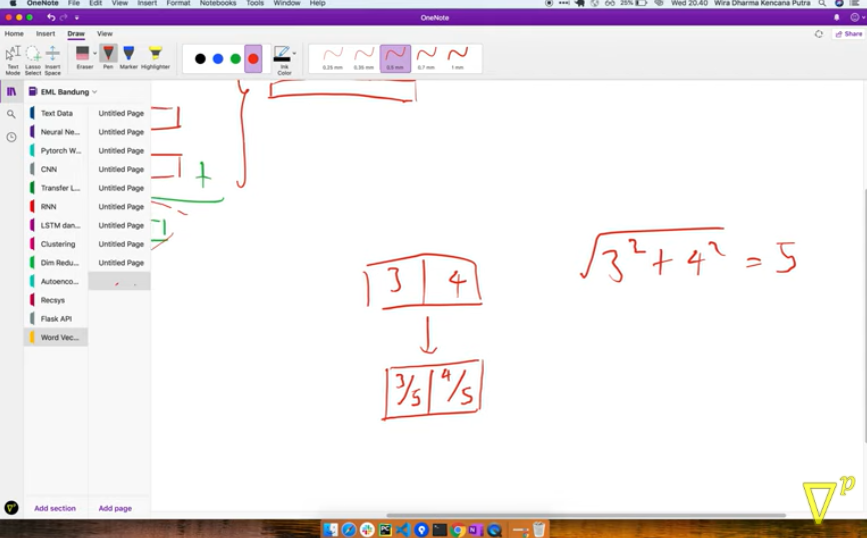

baru vektor vektor tersebut setelah dinormalisasikan kemudian dirata2kan

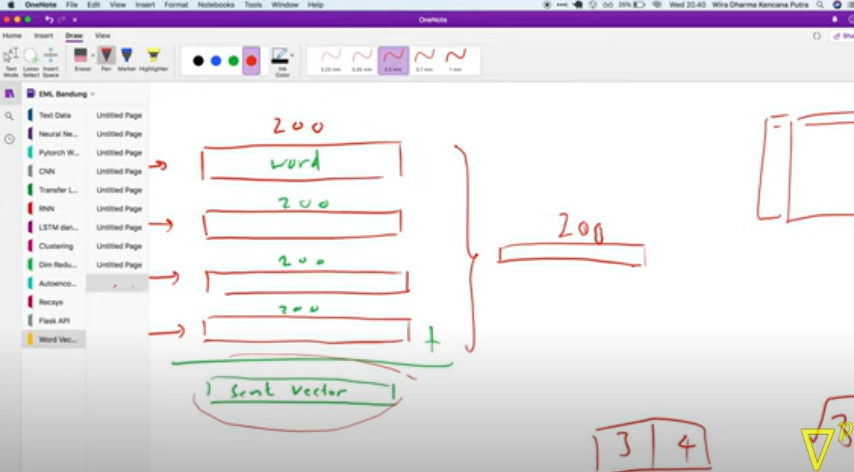


jadi dirata ratakan setelah di normalisasikan masing2 vektor, setelah sudah melalui prioses pytagoras

In [36]:
# import warnings
# warnings.simplefilter("error")

# import warnings
# warnings.filterwarnings("ignore", "Mean of empty slice")

In [37]:
# cara sebuah kalimat menjadi vektor padahal menggunakan perkata?
# tinggal looping dataset, untuk setiap kalimat didalam df.review (dataset), kita ubah menajdi vektor pakai fungsi normalisasi yang sudah dibuat sebelumnya
# kemudian masukan data kita, word2vec, masukan stopword
# dan itulah tabel akhir kita
vecs = [norm_sent_vector(sentence, w2v, sw_indo) for sentence in df.review]

# kemudian jadikan numpy array, karna di scikit learn mintanya numpy array
vecs = np.array(vecs)

#hasil akhir bentuknya tabular
vecs

array([[ 0.01395242,  0.01642321,  0.02153755, ...,  0.00506293,
         0.0522751 ,  0.04779267],
       [ 0.00678785, -0.00438792, -0.01435712, ...,  0.00336677,
         0.04216173,  0.03890474],
       [-0.01509156,  0.00353492, -0.0003146 , ...,  0.02732719,
         0.11912007,  0.01115901],
       ...,
       [-0.06947844, -0.03296062,  0.00397958, ..., -0.02040123,
         0.0746479 ,  0.03320095],
       [-0.02999653,  0.00987775, -0.02062067, ...,  0.05438147,
         0.06629571,  0.02657418],
       [-0.04518   ,  0.01070136,  0.01211465, ..., -0.00684987,
         0.09708023,  0.00261596]])

In [38]:
vecs.shape

(1782, 128)

#### apakah fasttext lebih baik? mari buktikan

### Dataset Splitting - pilih stratify (karna ini klasifikasi)

In [41]:
X = vecs #datanya sudah berbentuk tabular
y = df.rate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1425, 128), (357, 128), (1425,), (357,))

### Training - SVM - RandomSearchCV

In [42]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [43]:
pipeline = Pipeline([
    ('algo', SVC(max_iter=500))
])

model = RandomizedSearchCV(pipeline, rsp.svm_params, cv=5, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   40.5s finished
C:\Users\Niken Amelia\.conda\envs\jcop_wv\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 12.746711578215054, 'algo__gamma': 0.4374364439939081}
0.9031578947368422 0.8378947368421052 0.8235294117647058


### Evaluation

In [44]:
from jcopml.plot import plot_confusion_matrix

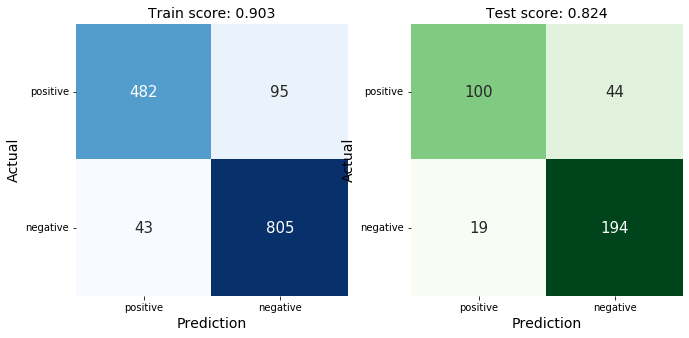

In [45]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)